PRUNING FILTERS FOR EFFICIENT CONVNETS (not in date with code)
===

**Reference**: https://arxiv.org/pdf/1608.08710.pdf

**Author**: `Minseong Kim` (tyui592@gmail.com)

### Imports

In [1]:
import os
os.environ['JUPYTER'] = 'True'
# os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-93.7%.pth'
# authors' pruning scheme
# os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-pruned-93.4%.pth --prune-layers conv1 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 32 256 256 256 256 256 256'

# authors' pruning scheme, with alternative criteria
# os.environ['JUPYTER_ARGS'] = '--action test --load-path model.pth --prune-layers conv1 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 32 256 256 256 256 256 256 --alternative-criteria'

# alternative pruning scheme, with alternative criteria
os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-pruned-92.5%.pth  --prune-layers conv1 conv2 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 32 32 256 384 384 384 384 384 --alternative-criteria'

import numpy as np
import matplotlib.pyplot as plt

from pthflops import count_ops

import torch

from utils import args
from utils.model import get_model
from utils.data import get_dataloader
from procedures.train import train_network
from procedures.evaluate import test_network, test_step
from procedures.prune import prune_step

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Pretrained Model Accuracy

In [2]:
accuracy = test_network()
model = get_model().to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

inp = torch.randn(1, 3, 32, 32).to(device)
count_ops(model, inp)

Files already downloaded and verified
Testing network...
Testing network (15.27), 	Accuracy: 92.28
Number of parameters: 7556218
Operation      OPS        
-------------  ---------  
features_0     917504     
features_1     98304      
features_2     98304      
features_3     9469952    
features_4     98304      
features_5     98304      
features_6     36864      
features_7     9469952    
features_8     65536      
features_9     65536      
features_10    37781504   
features_11    65536      
features_12    65536      
features_13    24576      
features_14    18890752   
features_15    32768      
features_16    32768      
features_17    37765120   
features_18    32768      
features_19    32768      
features_20    37765120   
features_21    32768      
features_22    32768      
features_23    12288      
features_24    9441280    
features_25    12288      
features_26    12288      
features_27    4720640    
features_28    10240      
features_29    10240      
feature

(171536074,
 [['features_0', 917504],
  ['features_1', 98304],
  ['features_2', 98304],
  ['features_3', 9469952],
  ['features_4', 98304],
  ['features_5', 98304],
  ['features_6', 36864],
  ['features_7', 9469952],
  ['features_8', 65536],
  ['features_9', 65536],
  ['features_10', 37781504],
  ['features_11', 65536],
  ['features_12', 65536],
  ['features_13', 24576],
  ['features_14', 18890752],
  ['features_15', 32768],
  ['features_16', 32768],
  ['features_17', 37765120],
  ['features_18', 32768],
  ['features_19', 32768],
  ['features_20', 37765120],
  ['features_21', 32768],
  ['features_22', 32768],
  ['features_23', 12288],
  ['features_24', 9441280],
  ['features_25', 12288],
  ['features_26', 12288],
  ['features_27', 4720640],
  ['features_28', 10240],
  ['features_29', 10240],
  ['features_30', 2361344],
  ['features_31', 10240],
  ['features_32', 10240],
  ['features_33', 3840],
  ['features_34', 590336],
  ['features_35', 2560],
  ['features_36', 2560],
  ['features_37

### Graph the Normalized Absolute Sum of the Filter Weights
This is Figure 2 (a) of the paper.

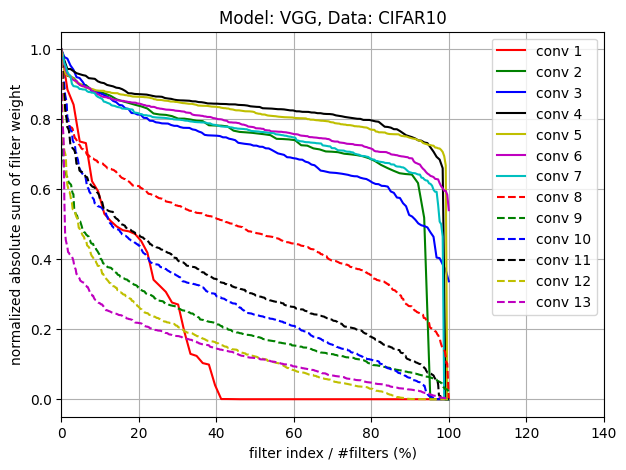

In [3]:
args.load_path = './pretrained_models/VGG16-CIFAR10-93.7%.pth'

colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']
plt.figure(figsize=(7, 5))
conv_count = 0
model = get_model()
for layer in model.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count % len(colors)] + lines[conv_count // len(colors)]
        
        # Weights are out_ch x in_ch x k1 x k2
        fw = layer.weight.data.cpu().numpy()
        
        # Sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # Normalize with maximum value
        normalized_abs_sum = sorted_abs_sum / sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label="conv %d" % conv_count)
        
plt.title("Model: %s, Data: %s" % (args.model, args.dataset))        
plt.ylabel("normalized absolute sum of filter weight")
plt.xlabel("filter index / #filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
# plt.savefig("plots/figure1.png", dpi=150, bbox_inches='tight')
plt.show()        

### Graph the Accuracy of the Network after Pruning
This is Figure 2 (b) of the paper.

Prune each layer 

In [2]:
args.load_path = './pretrained_models/VGG16-CIFAR10-93.7%.pth'
args.smarter_uniqueness = True

prune_step_ratio = 1 / 8
max_channel_ratio = 0.90 

args.load_path = './pretrained_models/VGG16-CIFAR10-93.7%.pth'
prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']
accuracies = {}

dataloader = get_dataloader(training=False)
model = get_model(prune=False).to(device)
accuracy = test_step(model, dataloader)

for conv, channel in zip(prune_layers, prune_channels): 
    print(f"Pruning {conv}")
    
    accuracies[conv] = [accuracy]
            
    # Remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel * max_channel_ratio), int(1 / prune_step_ratio), dtype=np.int32)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):        
        model = prune_step(model, [conv], [steps[i]], False)
        
        model = model.to(device)
        accuracy = test_step(model, dataloader)
        accuracies[conv].append(accuracy)

Files already downloaded and verified
Pruning conv1
Pruning conv2
Pruning conv3
Pruning conv4
Pruning conv5
Pruning conv6
Pruning conv7
Pruning conv8
Pruning conv9
Pruning conv10


OSError: [Errno 22] Invalid argument

Plot the accuracy graph

In [ ]:
plt.figure(figsize=(7, 5))
for index, (key, value) in enumerate(accuracies.items()):
    line_style = colors[index % len(colors)] + lines[index // len(colors)] + 'o'
    plt.plot(np.linspace(0, 90, len(value)), value, line_style, label=key)

plt.title("Model: %s, Data: %s, pruned smallest filters" % (args.model, args.dataset))        
plt.ylabel("Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
# plt.savefig("plots/figure2_smarter.png", dpi=150, bbox_inches='tight')
plt.show()                

### Graph the Accuracy of the Network after Pruning with Retraining
This is Figure 2 (c) of the paper.

Prune each layer with 1 epoch of retraining

In [3]:
args.epochs = 1
args.lr = 0.0001

accuracies = {}

for conv, channel in zip(prune_layers, prune_channels):    
    print(f"Pruning {conv}")
    
    accuracies[conv] = [accuracy]
    
    model = get_model()
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel * max_channel_ratio), int(1 / prune_step_ratio), dtype=np.int32)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):        
        model = prune_step(model, [conv], [steps[i]], False)
        train_network(model=model, write=False)
        accuracy = test_step(model, dataloader)      
        accuracies[conv].append(accuracy)

Pruning conv1
Files already downloaded and verified
Epoch 1 (42.76497721672058), 	 Accuracy: 99.9320652173913, 	 Loss: 0.0038642520655412225
Files already downloaded and verified
Epoch 1 (37.56763505935669), 	 Accuracy: 99.79219948849105, 	 Loss: 0.008703046697191893
Files already downloaded and verified
Epoch 1 (39.983455419540405), 	 Accuracy: 99.66632033248082, 	 Loss: 0.010764082971727476
Files already downloaded and verified
Epoch 1 (38.08072280883789), 	 Accuracy: 96.75751278772378, 	 Loss: 0.11120838852599263
Files already downloaded and verified
Epoch 1 (36.84073853492737), 	 Accuracy: 95.13746803069054, 	 Loss: 0.16504060700535775
Files already downloaded and verified
Epoch 1 (37.82200479507446), 	 Accuracy: 77.73697250639387, 	 Loss: 0.7177659744024276
Files already downloaded and verified
Epoch 1 (121.58108305931091), 	 Accuracy: 67.4320652173913, 	 Loss: 0.9831119507551194
Pruning conv2
Files already downloaded and verified


KeyboardInterrupt: 

Plot the accuracy graph

In [ ]:
plt.figure(figsize=(7, 5))
for index, (key, value) in enumerate(accuracies.items()):
    line_style = colors[index % len(colors)] + lines[index // len(colors)] + 'o'
    plt.plot(np.linspace(0, 90, len(value)), value, line_style, label=key)

plt.title("Model: %s, Data: %s, pruned smallest filters, retrained %d epochs" % (args.model, args.dataset, args.epochs))        
plt.ylabel("Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("plots/figure2.png", dpi=150, bbox_inches='tight')
plt.show()                